# Netoyage des données : Typage des données

Cette feuille commence par ouvrir les fichiers CSV avec pandas et esuite elle les type correctement et enregistre le tout sous format ***parquet***

In [1]:
WORK_DIR="."

## Les  imports

In [2]:
# !pip install fastparquet
# !pip install pgeocode

In [3]:
import zipfile
import xml.sax
import csv
import glob
import logging
import shutil
import os
import pandas as pd
import numpy as np

In [4]:
os.chdir(WORK_DIR)
print('current work dir is:', os.getcwd())

current work dir is: /home/houcine/workspace/school-eda-serviceStations


### import to clean geo data

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pgeocode
nomi = pgeocode.Nominatim('fr')

In [6]:
print('current work dir is:', os.getcwd())

current work dir is: /home/houcine/workspace/school-eda-serviceStations


limiter le nombre de lignes à afficher à 4 au lieu de faire un head() + un tail() il suffira d'afficher la DataFrame

In [7]:
pd.options.display.max_rows = 4

## Typage des DataFrames

### chargement de **pdv**

In [8]:
pdv = pd.read_csv('pdv.csv', dtype={"annee":str})
pdv

/home/houcine/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,annee,id,latitude,longitude,cp,pop,ouverture_debut,ouverture_fin,ouverture_saufjour,adresse,ville
0,2019,1000001,4620114.0,519791.0,1000,R,NaN,NaN,NaN,596 AVENUE DE TREVOUX,SAINT-DENIS-LèS-BOURG
1,2019,1000002,4621842.0,522767.0,1000,R,NaN,NaN,NaN,16 Avenue de Marboz,BOURG-EN-BRESSE
...,...,...,...,...,...,...,...,...,...,...,...
136710,2016,96600001,4875637.0,241048.0,94600,R,07:30:27,20:30:27,Dimanche,16 Avenue de Newburn,Choisy-le-Roi
136711,2016,99999001,4853943.0,749812.0,99999,R,01:00:00,01:00:00,NaN,station test,test


### cleaning ***longitude*** and ***latitude***

In metropolitan France :
<br>
the **latitude**  is between 42 and 51
<br>
and **longitude** is between -5 and 10

#### First we need to scale **longitude** and **latitude** correctly

The vaste majority should be scaled by 100,000. but there are some values that are already scaled properly.
So, we will only scale values that aren't in the right range.

Due to possible swaping between longitude and latitude we should take into account the global minimum range and global maximum range in order to scale correctly.
This means that values of longitude and latitude should be between -5 and 51.

In [9]:
# scale by 100,000 if longi or lati aren't in correct range
pdv.loc[~((-5 < pdv.latitude) &  (pdv.latitude < 51)),"latitude"]    /= 100000
pdv.loc[~((-5 < pdv.longitude) &  (pdv.longitude < 51)), "longitude"] /= 100000

We would like to drop incorrect longitude and latitude but first we can correct the ones that were inversed

In [10]:
# handling inversed values
sub_pdv = pdv.loc[
            (42 <= pdv.longitude)&\
            (pdv.longitude <= 51)&\
            (-5 <= pdv.latitude)&\
            (pdv.latitude <= 10)]

the idea behind this step is this :
<br>
we compare longitude and latitude of the postal code with longitude and latitude of the **pdv** file

In [100]:
# loop over all sub_pdv values by using their original index (the one in pdv dataframe)
for index in sub_pdv.index:
    cp        = sub_pdv.loc[index,["cp"]][0]
    latitude  = sub_pdv.loc[index,["latitude"]][0]
    longitude = sub_pdv.loc[index,["longitude"]][0]
    
    # geographical informations associated to this postal code (note that we are only using France postal codes)
    geo_info = nomi.query_postal_code(cp)
    
    # calculating the squared difference between the postal code longitude
    # and latitude and we will compare them the to longitude and latitude of the station
    lati_diff_squared = (latitude - geo_info.longitude)**2
    long_diff_squared = (longitude - geo_info.latitude)**2
    
    is_it_near = lati_diff_squared < 2 and\
                     long_diff_squared < 2
    
    if not is_it_near:
        print("index :",index)
        print("\t cp",cp, ":",longitude, latitude)
        
    # print(res['country code'], res.postal_code)

index : 37198
	 cp 13546 : 43.506 5.399
index : 37408
	 cp 14700 : 46.165 0.204
index : 37898
	 cp 20148 : 43.72 7.292000000000001
index : 39165
	 cp 31076 : 43.608999999999995 1.3969999999999998
index : 42056
	 cp 53102 : 48.302 -0.622
index : 42753
	 cp 59156 : 48.858999999999995 2.347
index : 43240
	 cp 61790 : 48.787 1.666
index : 44183
	 cp 68124 : 48.086000000000006 7.314
index : 44579
	 cp 70004 : 47.635 6.157
index : 45804
	 cp 78205 : 48.981 1.689
index : 46819
	 cp 85804 : 46.696000000000005 -1.9280000000000002
index : 46846
	 cp 86102 : 46.792 0.526
index : 95941
	 cp 86102 : 46.79115 0.52572
index : 120322
	 cp 56890 : 47.6831 -5.0996110000000005e-05
index : 135477
	 cp 86102 : 46.79115 0.52572


after manually verifying the **latitude** and **longitude** that we couldn't find with *"pgeocode"* library 
<br>
we conclude that all **longitudes** and **latitudes** that were in the correct range were swaped

### swap values

In [11]:
lat = sub_pdv.latitude.copy()
sub_pdv.loc[:,"latitude"] = sub_pdv.longitude
sub_pdv.loc[:,"longitude"] = lat
sub_pdv

/home/houcine/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,annee,id,latitude,longitude,cp,pop,ouverture_debut,ouverture_fin,ouverture_saufjour,adresse,ville
502,2019,6190006,43.763940,7.480690,6190,R,NaN,NaN,NaN,175 Avenue Louis Pasteur,ROQUEBRUNE-CAP-MARTIN
534,2019,6220004,43.579880,7.062040,6220,R,NaN,NaN,NaN,D6007,Vallauris
...,...,...,...,...,...,...,...,...,...,...,...
136478,2016,94500001,48.823150,2.494980,94500,R,06:00:00,21:00:00,NaN,ral de Gaulle,CHAMPIGNY-SUR-MARNE
136665,2016,95500002,48.967186,2.464734,95500,R,05:30:00,20:30:00,NaN,RN 370,GONESSE


In [12]:
# update the originale DataFrame and verify it
pdv.update(sub_pdv)
pdv.loc[sub_pdv.index]

,annee,id,latitude,longitude,cp,pop,ouverture_debut,ouverture_fin,ouverture_saufjour,adresse,ville
502,2019,6190006.0,43.763940,7.480690,6190,R,NaN,NaN,NaN,175 Avenue Louis Pasteur,ROQUEBRUNE-CAP-MARTIN
534,2019,6220004.0,43.579880,7.062040,6220,R,NaN,NaN,NaN,D6007,Vallauris
...,...,...,...,...,...,...,...,...,...,...,...
136478,2016,94500001.0,48.823150,2.494980,94500,R,06:00:00,21:00:00,NaN,ral de Gaulle,CHAMPIGNY-SUR-MARNE
136665,2016,95500002.0,48.967186,2.464734,95500,R,05:30:00,20:30:00,NaN,RN 370,GONESSE


Now, latitudes and longitudes that remain outside of the correcte range will be converted to **Nan**

In [13]:
d = pdv.loc[(-5 > pdv.longitude) | (pdv.longitude > 10) | (pdv.latitude > 51) |  (pdv.latitude < 42)]

In [14]:
d

,annee,id,latitude,longitude,cp,pop,ouverture_debut,ouverture_fin,ouverture_saufjour,adresse,ville
1221,2019,13015012.0,0.000000,0.000000,13015,R,NaN,NaN,NaN,"20-22, RN DE ST ANTOINE",MARSEILLE
2086,2019,20000002.0,41.933360,8.744030,20090,R,NaN,NaN,NaN,Route du Bord de Mer,Ajaccio
...,...,...,...,...,...,...,...,...,...,...,...
135935,2016,91220003.0,-20.949714,55.295261,97420,R,01:00:00,01:00:00,NaN,19 Avenue du 19 Mars 1946,Le Port
136282,2016,93240003.0,62.606560,2.649195,93240,R,06:00:34,22:00:34,NaN,17 Avenue Marcel Cachin,STAINS


In [15]:
d.loc[:,"latitude"] = np.nan
d.loc[:,"longitude"] = np.nan

In [16]:
pdv.update(d)

/home/houcine/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


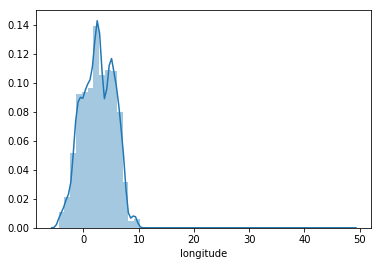

In [17]:
sns.distplot(pdv.dropna().longitude)

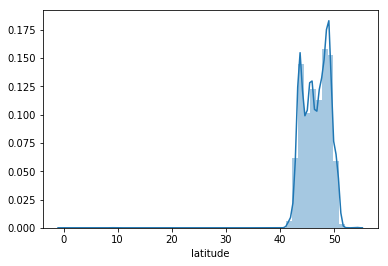

In [18]:
sns.distplot(pdv.dropna().latitude)

we can conclde that the vast majority of longitude and latitude are correcte now. <br>
of course we can add some modifications but I am satisfied with the results I have got.

correcting one ***cp***

In [19]:
pdv.loc[pdv.cp=="35***","cp"] = 35000

- **convertion des categories**

columns **'annee','pop','ouverture_saufjour'** it will be better to consider them as categories

In [20]:
pdv['annee']              = pdv['annee'].astype('category')
pdv['pop']                = pdv['pop'].astype('category')
pdv['ouverture_saufjour'] = pdv['ouverture_saufjour'].astype('category')

- **convertion des dates et temps**

In [21]:
mask = pdv['ouverture_debut'].str.len() == 5
pdv.loc[mask,'ouverture_debut'] = pdv.loc[mask,'ouverture_debut'] + ":00"

In [22]:
mask = pdv['ouverture_fin'].str.len() == 5
pdv.loc[mask,'ouverture_fin'] = pdv.loc[mask,'ouverture_fin'] + ":00"

Pour pouvooir faire des calcule sur des heures, on les converte en *timedelta*

In [23]:
pdv['ouverture_debut'] = pd.to_timedelta((pdv['ouverture_debut']))
pdv['ouverture_fin']   = pd.to_timedelta((pdv['ouverture_fin']))

In [24]:
pdv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136712 entries, 0 to 136711
Data columns (total 11 columns):
annee                 136712 non-null category
id                    136712 non-null float64
latitude              135706 non-null float64
longitude             135728 non-null float64
cp                    136712 non-null object
pop                   136712 non-null category
ouverture_debut       124114 non-null timedelta64[ns]
ouverture_fin         124114 non-null timedelta64[ns]
ouverture_saufjour    21174 non-null category
adresse               136712 non-null object
ville                 136709 non-null object
dtypes: category(3), float64(3), object(3), timedelta64[ns](2)
memory usage: 8.7+ MB


tout est bon!

- **enregistrer la df compréssée**

In [25]:
pdv.to_parquet('pdv.gzip', engine='fastparquet',
               compression='gzip')

- **liberer la mémoire**

In [26]:
del pdv

### netoyage de **prix**

In [27]:
prix = pd.read_csv('prix.csv')

In [28]:
prix

,annee,id_pdv,nom,id,maj,valeur
0,2019,1000001,Gazole,1,2019-01-04T10:53:48,1328
1,2019,1000001,Gazole,1,2019-01-07T10:25:25,1348
...,...,...,...,...,...,...
28556965,2016,95870009,SP98,6,2016-12-31T00:12:00,1439
28556966,2016,95870009,SP98,6,2016-12-31T00:12:00,1439


In [29]:
prix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28556967 entries, 0 to 28556966
Data columns (total 6 columns):
annee     int64
id_pdv    int64
nom       object
id        int64
maj       object
valeur    int64
dtypes: int64(4), object(2)
memory usage: 1.3+ GB


**the DataFrame 'prix' is very large (1,3 GB). we can make it smaller by converting some variables to Categories.**

- **convertion to categories**

the columns **'id_pdv','annee','nom','id'** are good candidates to be converted to categories.

In [30]:
prix["id_pdv"] = prix["id_pdv"].astype('category')
prix["annee"]  = prix["annee"].astype('category')
prix["nom"]    = prix["nom"].astype('category')
prix["id"]     = prix["id"].astype('category')

In [31]:
prix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28556967 entries, 0 to 28556966
Data columns (total 6 columns):
annee     category
id_pdv    category
nom       category
id        category
maj       object
valeur    int64
dtypes: category(4), int64(1), object(1)
memory usage: 572.3+ MB


**we changed the volum of the dataframe from 1.3GB to 0.57GB**

- **convertion of 'Maj' date**

In [32]:
prix['maj'] = pd.to_datetime(prix['maj'])

In [33]:
prix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28556967 entries, 0 to 28556966
Data columns (total 6 columns):
annee     category
id_pdv    category
nom       category
id        category
maj       datetime64[ns]
valeur    int64
dtypes: category(4), datetime64[ns](1), int64(1)
memory usage: 572.3 MB


- **save the compressed df**

In [34]:
prix.to_parquet('prix.gzip', engine='fastparquet',
               compression='gzip')

- **liberer la mémoire**

In [35]:
del prix

### netoyage de **services**

In [36]:
services = pd.read_csv('services.csv')

In [37]:
services

,annee,id_pdv,service
0,2019,1000001,Station de gonflage
1,2019,1000001,"Vente de gaz domestique (Butane, Propane)"
...,...,...,...
962902,2016,96600001,Vente de gaz domestique
962903,2016,96600001,


- **convertion to categories**

the columns **'annee','id_pdv','service'** it will be better to convert the to categories.

In [38]:
services["annee"]   = services["annee"].astype('category')
services["id_pdv"]  = services["id_pdv"].astype('category')
services["service"] = services["service"].astype('category')

In [39]:
services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962904 entries, 0 to 962903
Data columns (total 3 columns):
annee      962904 non-null category
id_pdv     962904 non-null category
service    962904 non-null category
dtypes: category(3)
memory usage: 5.3 MB


In [40]:
services

,annee,id_pdv,service
0,2019,1000001,Station de gonflage
1,2019,1000001,"Vente de gaz domestique (Butane, Propane)"
...,...,...,...
962902,2016,96600001,Vente de gaz domestique
962903,2016,96600001,


- **save te compressed df**

In [41]:
services.to_parquet('services.gzip', engine='fastparquet',
               compression='gzip')

- **liberer la mémoire**

In [42]:
del services